In [1]:
import warnings
warnings.filterwarnings('ignore')

import keras
import pandas as pd
import numpy as np

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense

Using TensorFlow backend.


# LIME

In [2]:
df = pd.read_csv("my_code/test_dataset/dataset_test_2_0")

In [3]:
classifier = load_model('./models/my_models/classifier_model04.h5')

In [4]:
df_anomaly = df[df.label ==1]
df_normal = df[df.label == 0]

In [5]:
label_1 = df_anomaly["label"]
label_2 = df_normal["label"]

In [6]:
df_anomaly= df_anomaly.drop(["Unnamed: 0","label"],axis=1)
df_normal=df_normal.drop(["Unnamed: 0","label"],axis=1)

In [7]:
predicted_probabilities = classifier.predict(df_anomaly)

In [8]:
def assign_class(predicted_probabilities, threshold=0.5):
    classes = []
    for i in range(len(predicted_probabilities)):
        if(predicted_probabilities[i] >= threshold):
            classes.append(1)
        else:
            classes.append(0)
    return np.asarray(classes)

In [9]:
pred = assign_class(predicted_probabilities)

In [10]:
from sklearn.metrics import confusion_matrix
confusion_matrix(label_1,pred)

array([[ 0,  0],
       [20,  4]])

In [11]:
def flatten_predict(qc):
    global classifier
    qc = classifier.predict(qc)
    return qc.reshape(qc.shape[0])

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
import lime
import lime.lime_tabular
explainer = lime.lime_tabular.LimeTabularExplainer(df_anomaly, feature_names=df_anomaly.columns, class_names=["Probability"],mode="regression",discretize_continuous=False,verbose=True)

In [14]:
exp = explainer.explain_instance(df_anomaly.iloc[0], flatten_predict,num_features=10)

Intercept 0.08385625329967734
Prediction_local [0.06738066]
Right: 0.1881794


In [15]:
exp.show_in_notebook(show_all=False)

In [16]:
fn_pos = []
tp_pos = []
for i in range(len(pred)):
    if pred[i]==1:
        tp_pos.append(i)
    else:
        fn_pos.append(i)
fn_df = df_anomaly.iloc[fn_pos,]
tp_df = df_anomaly.iloc[tp_pos,]

In [132]:
from lime import submodular_pick
sp_obj = submodular_pick.SubmodularPick(explainer,fn_df.values, flatten_predict, num_exps_desired=5,sample_size=df_anomaly.shape[0])
sp_obj2 = submodular_pick.SubmodularPick(explainer,tp_df.values, flatten_predict, num_exps_desired=5,sample_size=df_anomaly.shape[0])

Intercept 0.08698322660649556
Prediction_local [0.153063]
Right: 0.38714778
Intercept 0.09006413043514427
Prediction_local [-0.19324416]
Right: 0.11942595
Intercept 0.08175903472832707
Prediction_local [0.17756703]
Right: 0.3558818
Intercept 0.08355258578615744
Prediction_local [0.20851835]
Right: 0.43252409
Intercept 0.08039866597402916
Prediction_local [0.14999566]
Right: 0.1881794
Intercept 0.08212317024727483
Prediction_local [0.16806929]
Right: 0.40984577
Intercept 0.0852746546392266
Prediction_local [0.06662687]
Right: 0.30139643
Intercept 0.08572236680910265
Prediction_local [0.1758724]
Right: 0.40752673
Intercept 0.08177125328466436
Prediction_local [0.02719569]
Right: 0.12560937
Intercept 0.08724957438064987
Prediction_local [0.18915045]
Right: 0.44054475
Intercept 0.08488006905936744
Prediction_local [0.16400433]
Right: 0.27397817
Intercept 0.08312277961362889
Prediction_local [0.17866332]
Right: 0.4107314
Intercept 0.08814473895555804
Prediction_local [0.00363924]
Right: 0.0

In [125]:
#change in sp_obj2 for tp, sp_obj for fn
W_fn=pd.DataFrame([dict(this.as_list()) for this in sp_obj2.explanations])

In [126]:
W_fn = W_fn.fillna(0)

In [127]:
M_df = W_fn[W_fn>0]

In [128]:
Min = W_fn[W_fn<0]

In [129]:
lst=[]
for i in M_df.describe():
    if M_df.describe()[i]["count"]>1:
        lst.append(i)
        

In [130]:
lst_2 = []

for i in Min.describe():
    if Min.describe()[i]["count"]>1:
        lst_2.append(i)

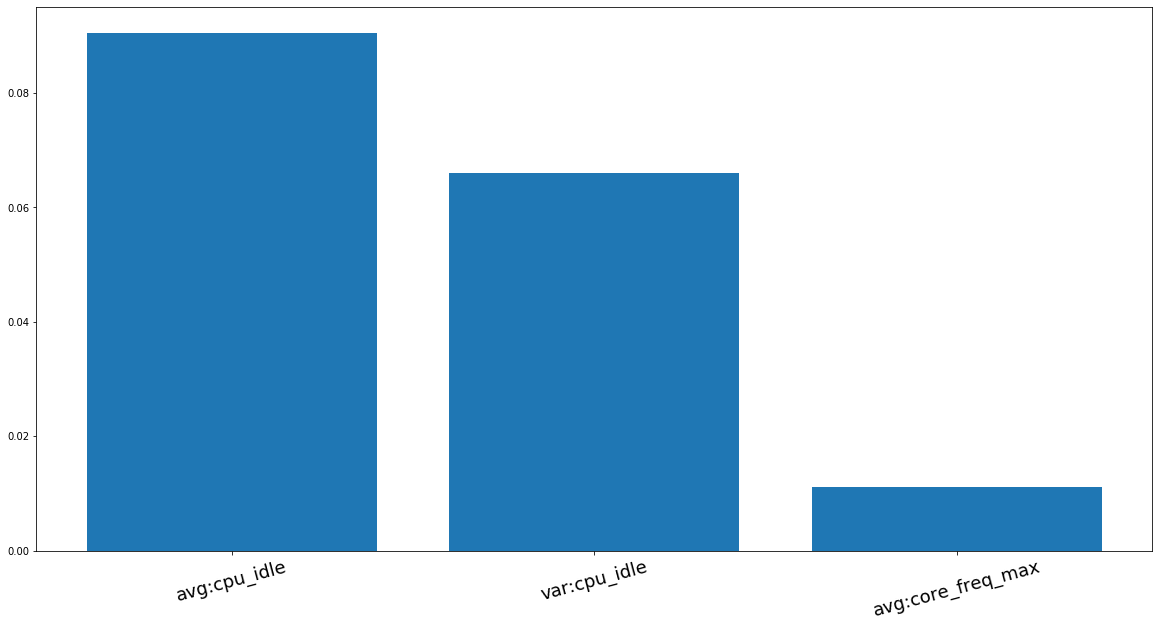

In [138]:
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(4)
features = [M_df.describe()[x]["count"]*M_df.describe()[x]["mean"] for x in lst ]


fig, ax = plt.subplots(figsize=(20,10))
plt.xticks(rotation=15,fontsize=18)
plt.bar(lst, features)
plt.savefig("./img/Count Features Anomaly TP Node c09s04.png",dpi=150)
plt.show()

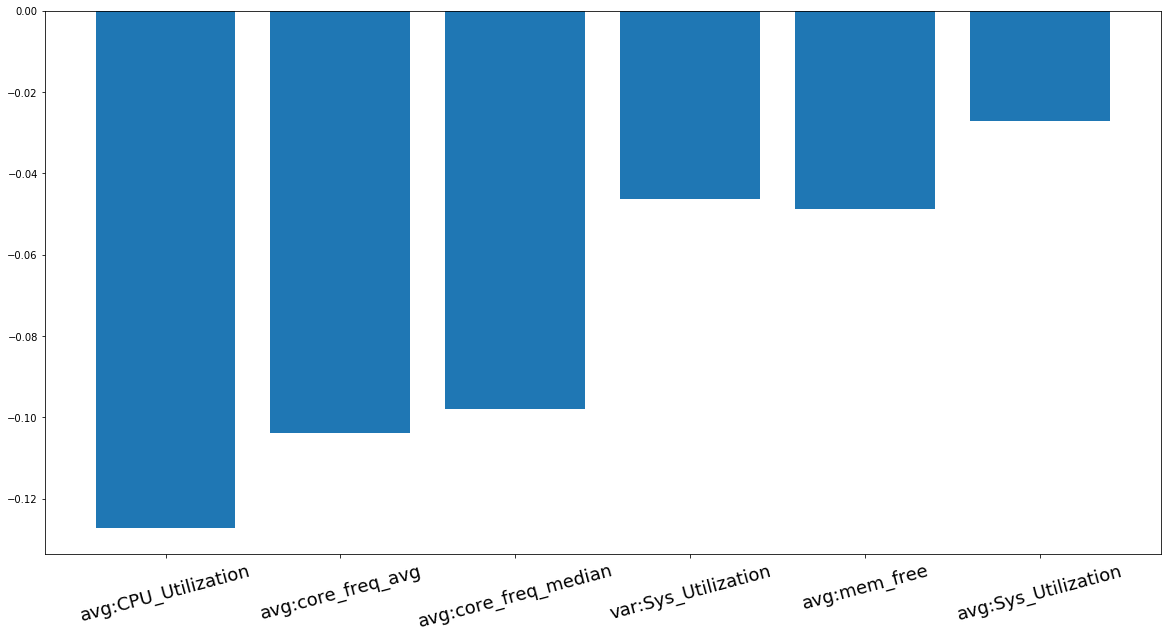

In [137]:
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(4)
features = [Min.describe()[x]["count"]*Min.describe()[x]["mean"] for x in lst_2]


fig, ax = plt.subplots(figsize=(20,10))
plt.xticks(rotation=15,fontsize=18)
plt.bar(lst_2, features)
plt.savefig("./img/Count Features Negative Anomaly TP Node c09s04.png",dpi=100)
plt.show()

# ACTIVATION VISUALIZATION

In [19]:
classifier = load_model('./models/my_models/classifier_model04.h5')

In [290]:
encoder = classifier.layers[0]

In [291]:
from keras import backend as K

layers_dim = dict()

for layer in encoder.layers:
    layers_dim[layer.name] = layer.get_output_at(0).get_shape().as_list()[1:]

#Map layer name with layer index
layers = dict()
index = None
for idx, layer in enumerate(encoder.layers):
    layers[layer.name] = idx

In [292]:
def get_activations(model, layer, X_batch):
    get_activations = K.function([model.layers[0].input, K.learning_phase()], [model.layers[layer].output,])
    activations = get_activations([X_batch,0])
    return activations


In [293]:
def get_activation_from_layer(model,layer_name,layers,layers_dim,data):
    acti = get_activations(model, layers[layer_name], data)[0]
    return acti


In [296]:
import numpy
import matplotlib.pyplot as plt
%matplotlib inline

#show activation in colormap
def show_activation_map(data,name):
    fig_n = 1
    for i in layers:
        act = get_activation_from_layer(encoder,i,layers,layers_dim,data)
        plt.figure(fig_n,figsize=(20,10))
        plt.subplot(6,1,fig_n)
        plt.xticks(numpy.arange(0,layers_dim[i][0],1),fontsize=7.5,rotation=90)
        plt.imshow(act, cmap="jet",aspect='auto')
        plt.colorbar()
        fig_n+=1
    plt.savefig("Activation Anomaly "+name+".png")
    plt.show()



In [297]:
predicted_probabilities = classifier.predict(df_anomaly)

In [298]:
def assign_class(predicted_probabilities, threshold=0.5):
    classes = []
    for i in range(len(predicted_probabilities)):
        if(predicted_probabilities[i] >= threshold):
            classes.append(1)
        else:
            classes.append(0)
    return np.asarray(classes)

In [299]:
pred = assign_class(predicted_probabilities)

In [82]:
fn = df_anomaly.iloc[[1,3,4,7,8,9,10,13,14,17,22,23,24]]

In [81]:
pred

array([1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1,
       0, 0, 0, 1, 1, 1, 1])

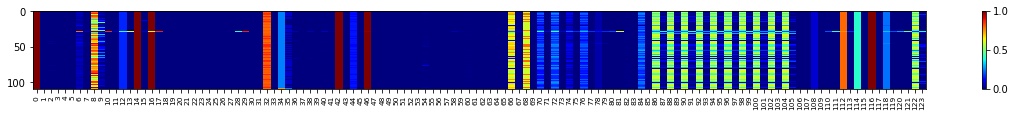

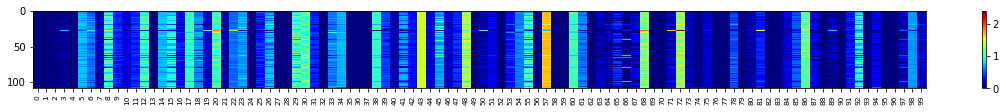

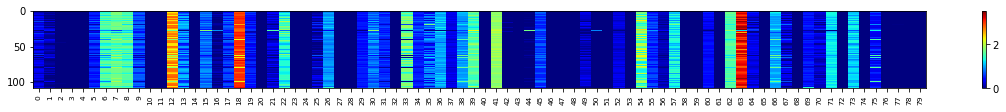

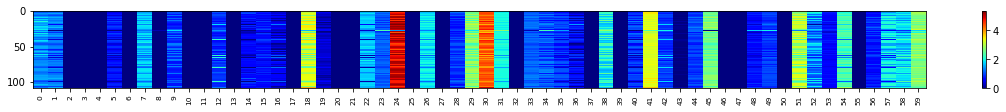

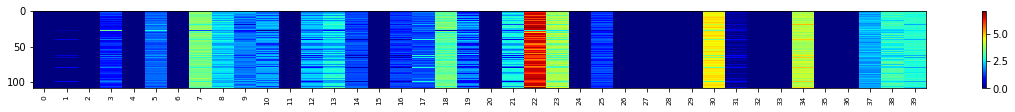

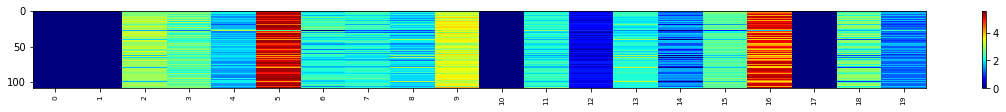

In [300]:
#pass df.values and name for saving img
show_activation_map(df_anomaly.values,"c12s09")
